In [3]:
import sys
import os

path = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, path + '/../')

from util.io import log_files
import importlib
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 150
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')

import numpy as np
import pandas as pd

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import tikzplotlib

In [4]:
CARTPOLE_LOG_DIR = "/Users/florentdelgrange/workspace/logs/05-07-21/CartPole-v0/"

In [3]:
importlib.reload(log_files)

cartpole = log_files.get_event_dataframe(
    CARTPOLE_LOG_DIR,
    regex='*PER*/**',
    # tags=['eval_elbo', 'policy_evaluation_avg_rewards', 'distortion', 'rate'],
    tags_renaming={'eval_elbo': 'ELBO'},
    run_name='prioritized replay',
    event_name='Cartpole-v0',
    value_dtype=None)
cartpole = cartpole.append(
    log_files.get_event_dataframeget_event_dataframeget_event_arrays(
        '/home/florent/workspace/logs/05-07-21/CartPole-v0/',
        regex='*[!PER]*/**',
        # tags=['eval_elbo', 'policy_evaluation_avg_rewards', 'distortion', 'rate'],
        tags_renaming={'eval_elbo': 'ELBO'},
        run_name='uniform replay',
        event_name='CartPole-v0',
        value_dtype=None))


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [4]:
cartpole

,step,value,tag,run,event
0,80,79.0,step,prioritized replay,Cartpole-v0
1,80,8.285763,loss,prioritized replay,Cartpole-v0
2,80,-4.3607244,ELBO,prioritized replay,Cartpole-v0
3,80,0.23103237,state_mse,prioritized replay,Cartpole-v0
4,80,0.67584395,reward_mse,prioritized replay,Cartpole-v0
...,...,...,...,...,...
1191905,10000,0.67,t_1,prioritized replay,Cartpole-v0
1191906,10000,0.5,t_2,prioritized replay,Cartpole-v0
1191907,10000,10.0,entropy_regularizer_scale_factor,prioritized replay,Cartpole-v0
1191908,10000,0.0,kl_annealing_scale_factor,prioritized replay,Cartpole-v0


In [5]:
cartpole['tag'].unique()

array(['step', 'loss', 'ELBO', 'state_mse', 'reward_mse', 'distortion',
       'rate', 'annealed_rate', 'entropy_regularizer', 'encoder_entropy',
       'marginal_encoder_entropy', 'transition_log_probs',
       'replay_buffer_frames', 'mean_state_bits_used', 't_1', 't_2',
       'entropy_regularizer_scale_factor', 'kl_annealing_scale_factor',
       'wis_exponent', 'policy_evaluation_avg_rewards', 'state_frequency'],
      dtype=object)

In [6]:
cartpole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191910 entries, 0 to 1191909
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   step    1191910 non-null  int64 
 1   value   1191910 non-null  object
 2   tag     1191910 non-null  object
 3   run     1191910 non-null  object
 4   event   1191910 non-null  object
dtypes: int64(1), object(4)
memory usage: 45.5+ MB


## Smoothing via moving Mean

In [88]:
importlib.reload(log_files)

cartpole = log_files.get_event_dataframe(
    CARTPOLE_LOG_DIR,
    regex='*PER*/**',
    tags=['distortion', 'rate'],
    run_name='prioritized replay',
    event_name='Cartpole-v0',
    smooth=['distortion'],
    smooth_window = {'distortion': 10})
cartpole = cartpole.append(
    log_files.get_event_dataframe(
        CARTPOLE_LOG_DIR,
        regex='*[!PER]*/**',
        tags=['distortion', 'rate'],
        run_name='uniform replay',
        event_name='CartPole-v0',
        smooth = ['distortion'],
        smooth_window = {'distortion': 10}))

In [89]:
distortion = cartpole[cartpole['tag'] == 'distortion']
distortion

,step,value,tag,smooth,run,event
0,80,1.711133,distortion,1.711133,prioritized replay,Cartpole-v0
2,160,-4.231040,distortion,-1.259953,prioritized replay,Cartpole-v0
4,240,-5.968990,distortion,-2.829632,prioritized replay,Cartpole-v0
6,320,-5.943729,distortion,-3.608157,prioritized replay,Cartpole-v0
8,400,-6.385389,distortion,-4.163603,prioritized replay,Cartpole-v0
...,...,...,...,...,...,...
24990,999680,31.966913,distortion,532.584418,uniform replay,CartPole-v0
24992,999760,2376.024658,distortion,757.128935,uniform replay,CartPole-v0
24994,999840,2411.503906,distortion,994.229483,uniform replay,CartPole-v0
24996,999920,976.991333,distortion,884.267142,uniform replay,CartPole-v0


<AxesSubplot:xlabel='step', ylabel='distortion'>

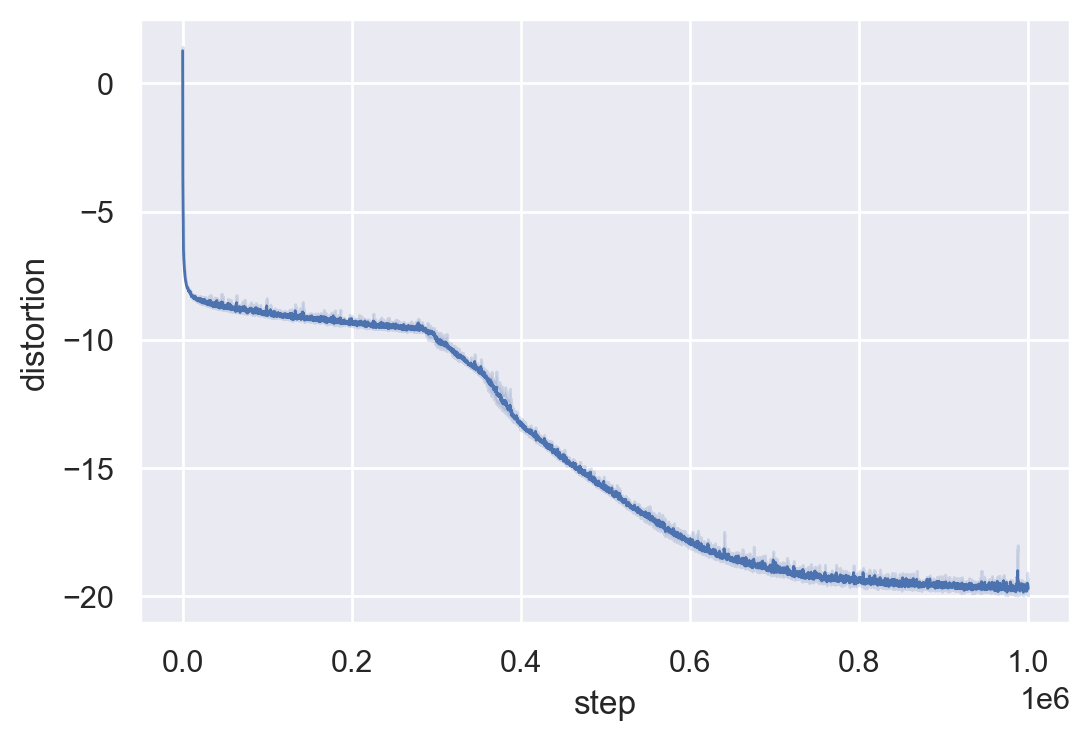

In [91]:
sns.set_theme(style="darkgrid")

sns.lineplot(
    data=distortion[distortion['run'] == 'prioritized replay'].rename(columns={'smooth': 'distortion'}),
    x='step',
    y='distortion',
    lw=1)

In [ ]:
sns.set_theme(style="darkgrid")
sns.relplot(data=distortion, x='step', y='smooth', row='run', kind='line')

In [87]:
moving_mean = distortion.rolling(window=10, min_periods=1, on='step').mean().rename(columns={'value': 'mov_mean'})
moving_mean

,step,mov_mean
5,80,1.711133
24,160,-1.259953
43,240,-2.829632
62,320,-3.608157
81,400,-4.163603
...,...,...
1191817,9680,-8.297065
1191836,9760,-8.292442
1191855,9840,-8.302773
1191874,9920,-8.312493


In [88]:
distortion.join(moving_mean.set_index('step'), on='step')

,step,value,tag,run,event,mov_mean
5,80,1.711133,distortion,prioritized replay,Cartpole-v0,1.711133
5,80,1.711133,distortion,prioritized replay,Cartpole-v0,-7.176819
5,80,1.711133,distortion,prioritized replay,Cartpole-v0,-17.124168
5,80,1.711133,distortion,prioritized replay,Cartpole-v0,-17.808241
5,80,1.711133,distortion,prioritized replay,Cartpole-v0,-7.301771
...,...,...,...,...,...,...
1191896,10000,-8.036464,distortion,prioritized replay,Cartpole-v0,-8.224282
1191896,10000,-8.036464,distortion,prioritized replay,Cartpole-v0,-8.035486
1191896,10000,-8.036464,distortion,prioritized replay,Cartpole-v0,-8.094818
1191896,10000,-8.036464,distortion,prioritized replay,Cartpole-v0,-8.340116


# Prioritized experience replay vs. uniform experience replay

In [ ]:
importlib.reload(log_files)

cartpole = log_files.get_event_dataframe(
    CARTPOLE_LOG_DIR,
    regex='*PER*/**',
    tags=['eval_elbo', 'policy_evaluation_avg_rewards'],
    tags_renaming={'eval_elbo': 'ELBO'},
    run_name='prioritized',
    event_name='Cartpole-v0')
cartpole = cartpole.append(
    log_files.get_event_dataframe(
        CARTPOLE_LOG_DIR,
        regex='*[!PER]*/**',
        tags=['eval_elbo', 'policy_evaluation_avg_rewards'],
        tags_renaming={'eval_elbo': 'ELBO'},
        run_name='uniform',
        event_name='CartPole-v0'))

In [ ]:
cartpole.info()

In [110]:
eval_elbo = cartpole[cartpole['tag'] == 'ELBO']
policy_eval_avg_rew = cartpole[cartpole['tag'] == 'policy_evaluation_avg_rewards']

In [111]:
eval_elbo

,step,value,tag,run,event
1,10000,1.732912,ELBO,prioritized,Cartpole-v0
1,10000,2.795293,ELBO,prioritized,Cartpole-v0
3,20000,4.838788,ELBO,prioritized,Cartpole-v0
5,30000,4.669662,ELBO,prioritized,Cartpole-v0
7,40000,5.173471,ELBO,prioritized,Cartpole-v0
...,...,...,...,...,...
191,960000,-699.732727,ELBO,uniform,CartPole-v0
193,970000,-133.100113,ELBO,uniform,CartPole-v0
195,980000,-43.534981,ELBO,uniform,CartPole-v0
197,990000,-246.219238,ELBO,uniform,CartPole-v0


In [96]:
policy_eval_avg_rew

,step,value,tag,run,event
0,10000,18.100000,policy_evaluation_avg_rewards,prioritized,Cartpole-v0
0,10000,29.799999,policy_evaluation_avg_rewards,prioritized,Cartpole-v0
2,20000,21.299999,policy_evaluation_avg_rewards,prioritized,Cartpole-v0
4,30000,24.799999,policy_evaluation_avg_rewards,prioritized,Cartpole-v0
6,40000,21.500000,policy_evaluation_avg_rewards,prioritized,Cartpole-v0
...,...,...,...,...,...
190,960000,200.000000,policy_evaluation_avg_rewards,uniform,CartPole-v0
192,970000,200.000000,policy_evaluation_avg_rewards,uniform,CartPole-v0
194,980000,200.000000,policy_evaluation_avg_rewards,uniform,CartPole-v0
196,990000,200.000000,policy_evaluation_avg_rewards,uniform,CartPole-v0


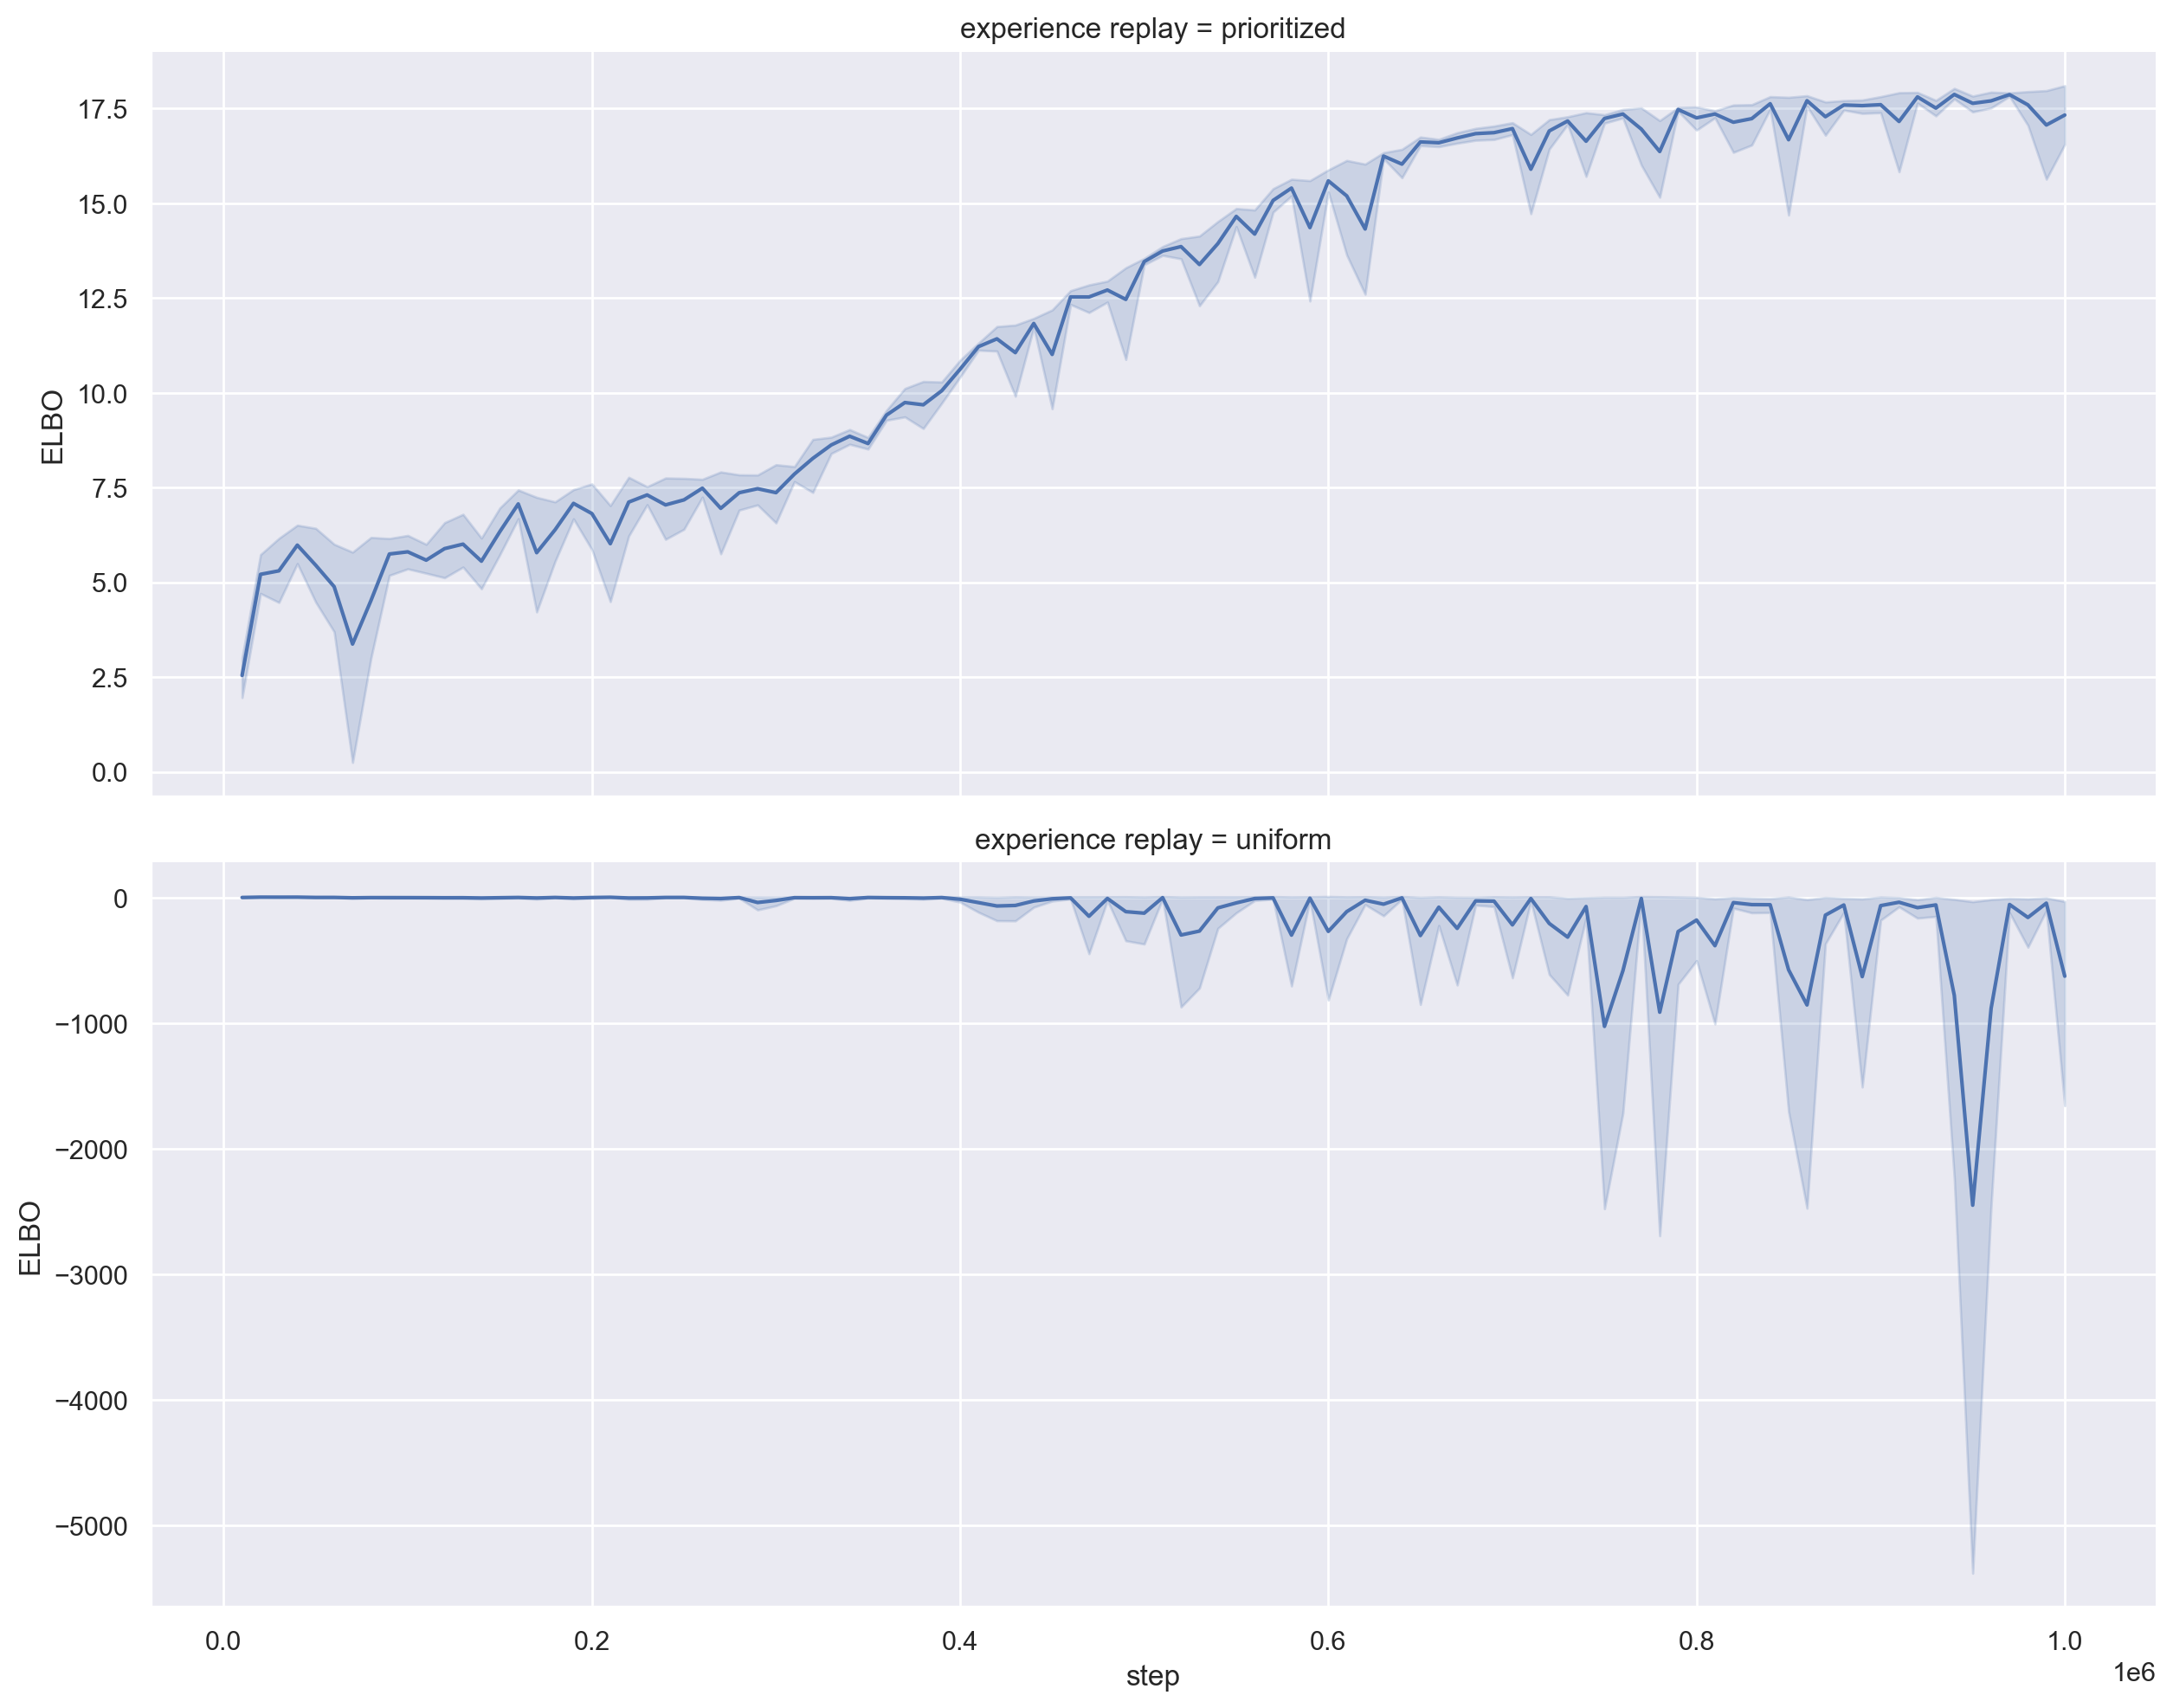

In [114]:
importlib.reload(log_files)

log_files.plot_elbo_evaluation(eval_elbo, compare_experience_replay=True, relplot=True, eval_elbo_tag='ELBO')

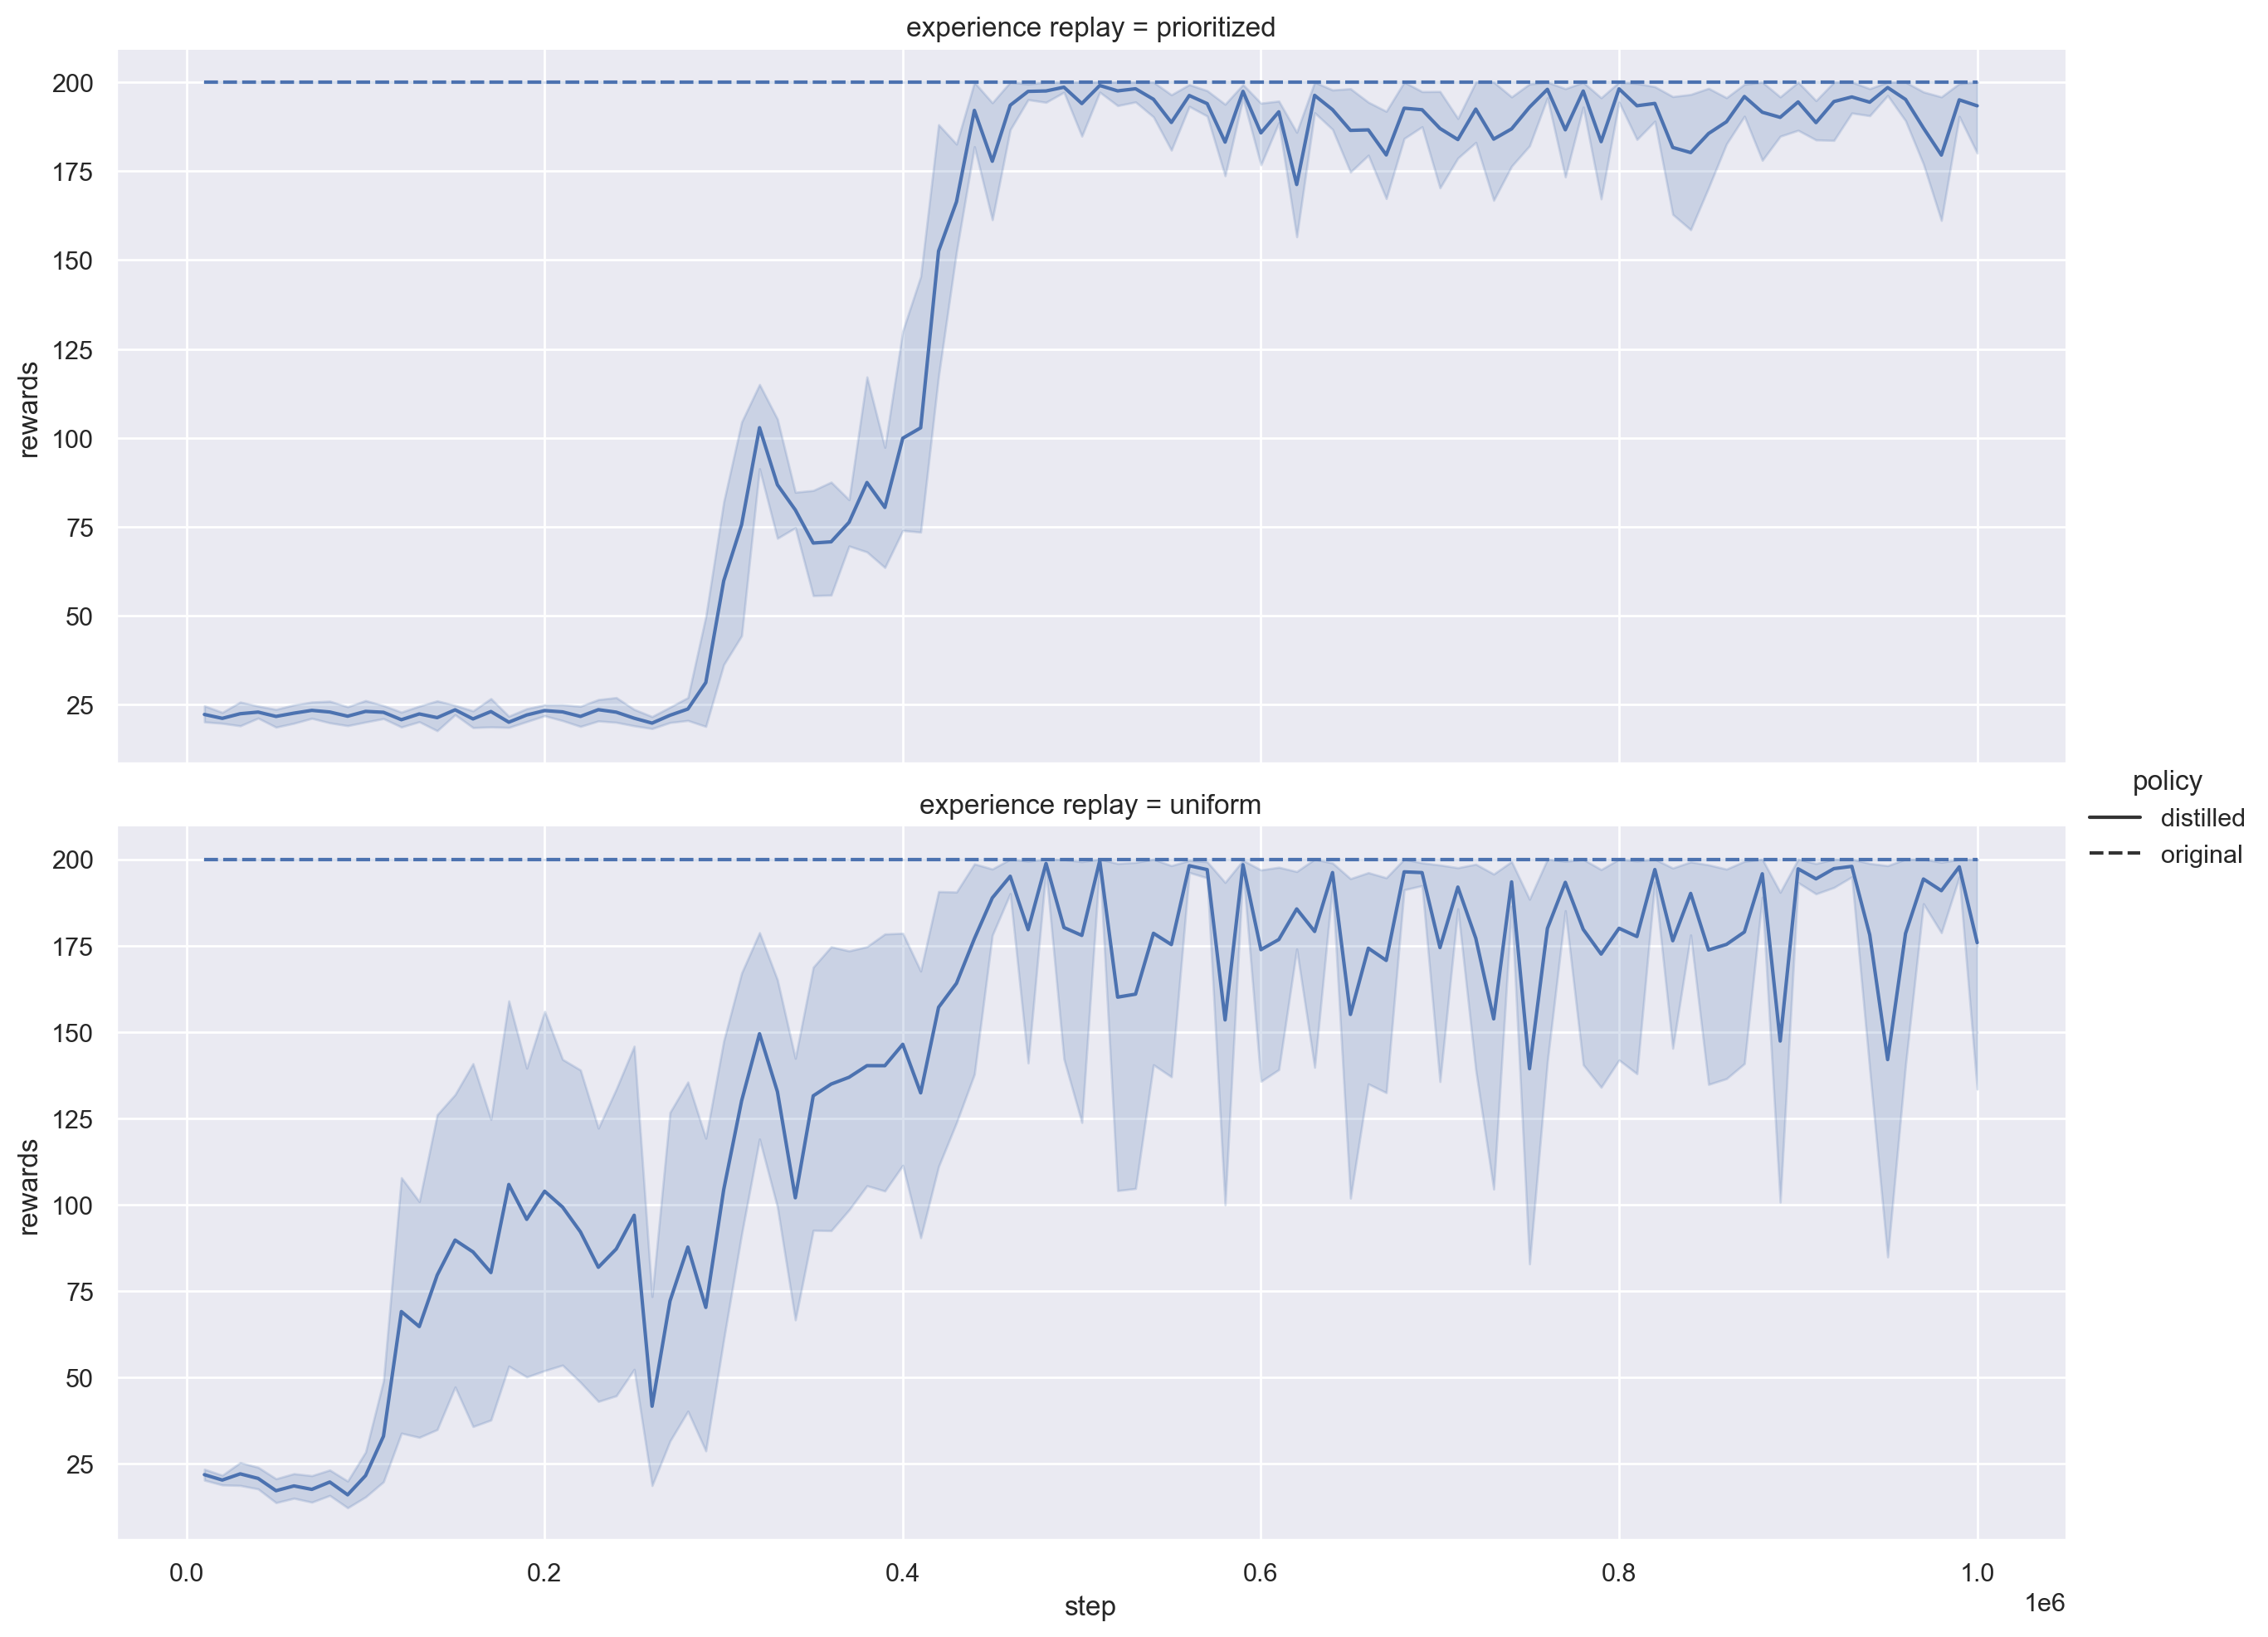

In [104]:
importlib.reload(log_files)

log_files.plot_policy_evaluation(cartpole, 200., compare_experience_replay=True, relplot=True)

## State distribution histogram

In [290]:
importlib.reload(log_files)

hist = log_files.get_event_dataframe(
    CARTPOLE_LOG_DIR,
    regex='*20210510*PER*/**',
    tags=['state_frequency'],
    run_name='prioritized',
    event_name='CartPole-v0',
    value_dtype=None)
hist = hist.append(
    log_files.get_event_dataframe(
        CARTPOLE_LOG_DIR,
        regex='*20210510*[!PER]*/**',
        tags=['state_frequency'],
        run_name='uniform',
        event_name='CartPole-v0',
        value_dtype=None))

In [291]:
hist

,step,value,tag,run,event
0,10000,"[[3.0, 139.3, 9143.0], [139.3, 275.6, 8522.0],...",state_frequency,prioritized,CartPole-v0
1,20000,"[[3.0, 139.3, 9073.0], [139.3, 275.6, 8441.0],...",state_frequency,prioritized,CartPole-v0
2,30000,"[[3.0, 139.3, 9074.0], [139.3, 275.6, 8527.0],...",state_frequency,prioritized,CartPole-v0
3,40000,"[[3.0, 139.3, 9128.0], [139.3, 275.6, 8545.0],...",state_frequency,prioritized,CartPole-v0
4,50000,"[[3.0, 139.3, 9084.0], [139.3, 275.6, 8624.0],...",state_frequency,prioritized,CartPole-v0
...,...,...,...,...,...
95,960000,"[[3.0, 139.3, 138233.0], [139.3, 275.6, 240.0]...",state_frequency,uniform,CartPole-v0
96,970000,"[[3.0, 139.3, 130608.0], [139.3, 275.6, 251.0]...",state_frequency,uniform,CartPole-v0
97,980000,"[[3.0, 139.3, 138041.0], [139.3, 275.6, 156.0]...",state_frequency,uniform,CartPole-v0
98,990000,"[[3.0, 139.3, 125357.0], [139.3, 275.6, 143.0]...",state_frequency,uniform,CartPole-v0


In [70]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   step    303 non-null    int64 
 1   value   303 non-null    object
 2   tag     303 non-null    object
 3   run     303 non-null    object
 4   event   303 non-null    object
dtypes: int64(1), object(4)
memory usage: 14.2+ KB


In [273]:
'tag' in hist

True

In [322]:
_df = hist[hist['run'] == 'prioritized']
_df[df['step'] == int(1e6)]

,step,value,tag,run,event
99,1000000,"[[11.0, 146.73333333333332, 4106.0], [146.7333...",state_frequency,prioritized,CartPole-v0


In [6]:
df = hist

def gen_random_bucket_values(bucket):
    return np.random.randint(low=bucket[..., 0], high=bucket[..., 1], size=(int(bucket[..., 2])))

def gen_mean_bucket_values(bucket):
    return np.repeat(
        np.floor(bucket[..., :2].mean()), bucket[..., 2].astype(int, casting='unsafe')
    ).astype(np.int32)


data = np.array(
    [np.concatenate([gen_mean_bucket_values(bucket) for bucket in value], axis=-1) for value in df['value']])

data

array([[  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023],
       ...,
       [  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023]], dtype=int32)

In [65]:
hist[hist['run'] == 'prioritized']['step']

0       10000
0       10000
1       20000
2       30000
3       40000
       ...   
96     970000
97     980000
98     990000
99    1000000
0       10000
Name: step, Length: 501, dtype: int64

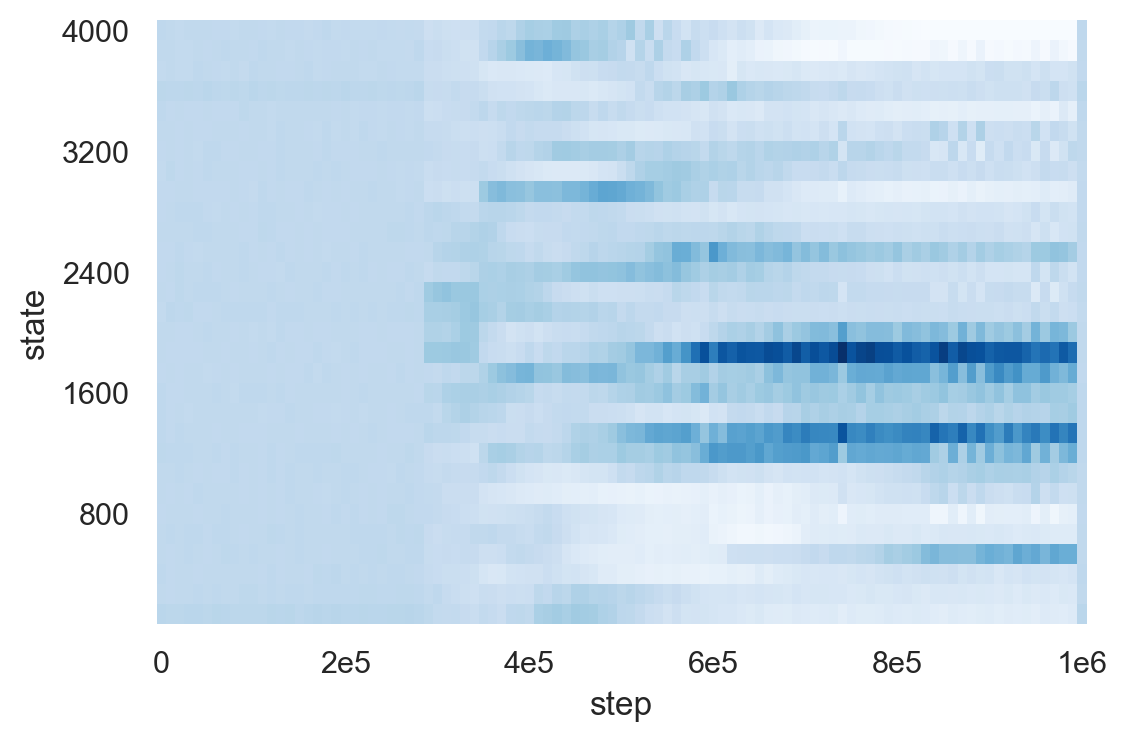

In [344]:
importlib.reload(log_files)

log_files.plot_histograms_per_step(hist[hist['run'] == 'prioritized'])
tikzplotlib.save("mytikz.tex")

<AxesSubplot:xlabel='step', ylabel='state'>

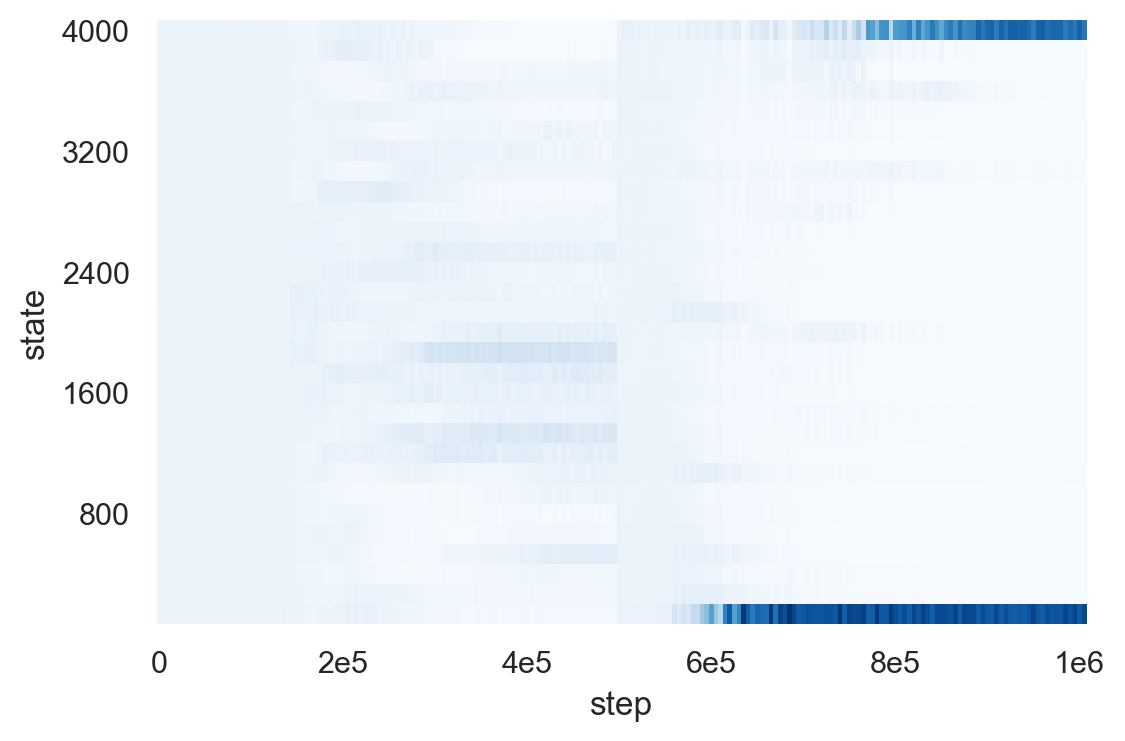

In [279]:
importlib.reload(log_files)

log_files.plot_histograms_per_step(hist[hist['run'] == 'uniform'], num_x_ticks=5)
tikzplotlib.save("mytikz.tex")

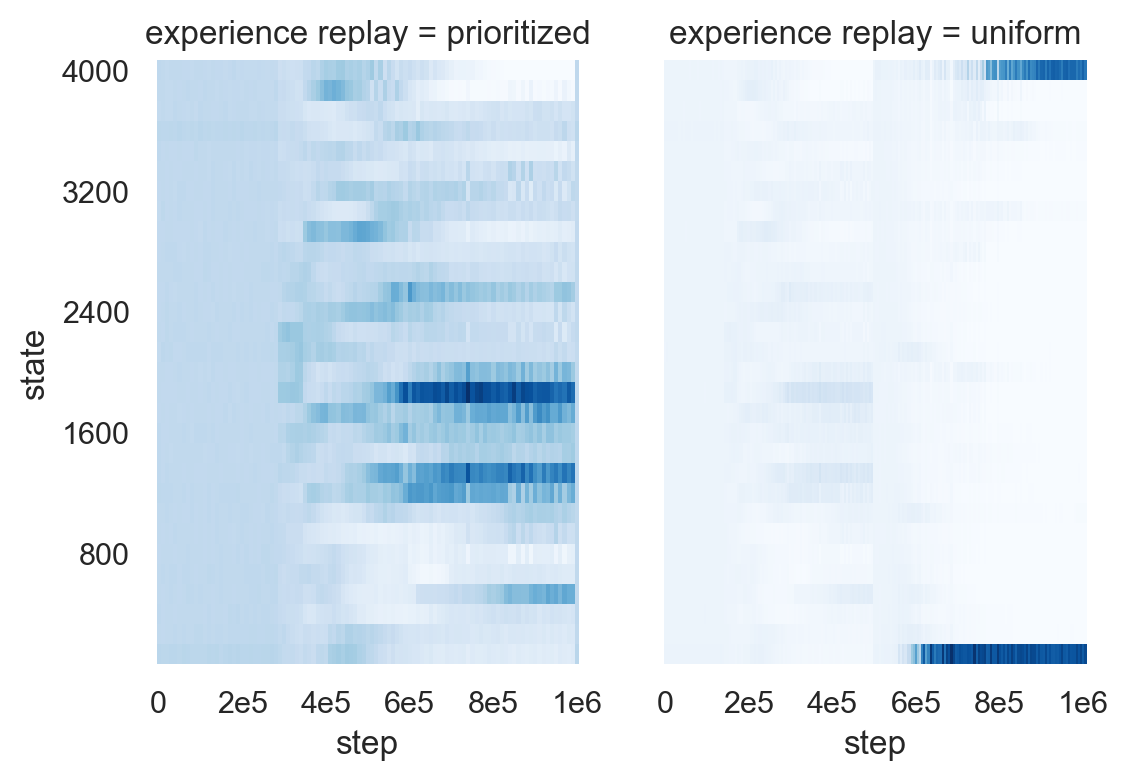

In [345]:
importlib.reload(log_files)

g = log_files.plot_histograms_per_step(hist, num_x_ticks=5, num_y_ticks=5)
tikzplotlib.save("mytikz.tex")

In [7]:
import time

start = time.time()

_df = pd.DataFrame({
    'state': data.flatten(),
    'step': np.array([[step] * len(states) for step, states in zip(df["step"], data)], dtype=np.int32).flatten(),
    # 'run': np.array([[run] * len(states) for run, states in zip(df['run'], data)]).flatten()
})

print('time to build:', time.time() - start)

_df

time to build: 42.48171067237854


,state,step
0,71,10000
1,71,10000
2,71,10000
3,71,10000
4,71,10000
...,...,...
385791995,4023,1000000
385791996,4023,1000000
385791997,4023,1000000
385791998,4023,1000000


In [10]:
df['run'].unique()

array(['prioritized', 'uniform'], dtype=object)

In [ ]:
import time

start = time.time()

_df = None

_df = pd.DataFrame({
    'state': data.flatten(),
    'step': np.array([[step] * len(states) for step, states in zip(df["step"], data)], dtype=np.int32).flatten(),
    'run': np.array([[run] * len(states) for run, states in zip(df['run'], data)]).flatten()
})

print('time to build:', time.time() - start)

_df

In [19]:
data

array([[  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023],
       ...,
       [  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023],
       [  71,   71,   71, ..., 4023, 4023, 4023]], dtype=int32)

In [16]:
import time

start = time.time()


def gen_mean_bucket_values(bucket):
    return np.repeat(
        np.floor(bucket[..., :2].mean()), bucket[..., 2].astype(int, casting='unsafe')
    ).astype(np.int32)

df = None

for run in hist['run'].unique():
    
    hist_run = hist[hist['run'] == run]
    
    data = np.array(
        [np.concatenate([gen_mean_bucket_values(bucket) for bucket in value], axis=-1)
         for value in hist_run['value']])
    
    _df = pd.DataFrame({
        'state': data.flatten(),
        'step': np.array(
            [[step] * len(states) for step, states in zip(hist_run["step"], data)], dtype=np.int32
        ).flatten(),
    })
    _df['run'] = run
    
    df = _df if df is None else df.append(_df)

print('time to build:', time.time() - start)

df

time to build: 36.408427000045776


,state,step,run
0,71,20000,prioritized
1,71,20000,prioritized
2,71,20000,prioritized
3,71,20000,prioritized
4,71,20000,prioritized
...,...,...,...
127487995,4023,1000000,uniform
127487996,4023,1000000,uniform
127487997,4023,1000000,uniform
127487998,4023,1000000,uniform


In [ ]:
prioritized_hist = df[df['run'] == 'prioritized']

In [45]:

shape = None
for step in prioritized_hist['step'].unique():
    if shape is None:
        shape = prioritized_hist[prioritized_hist['step'] == step].shape
    else:
        if prioritized_hist[prioritized_hist['step'] == step].shape != shape:
            print("step", step, ":", prioritized_hist[prioritized_hist['step'] == step].shape)


step 980000 : (1024000, 3)
step 1000000 : (1024000, 3)


In [ ]:
sns.displot(data=df, x='step', y='state', bins=30, col='run')

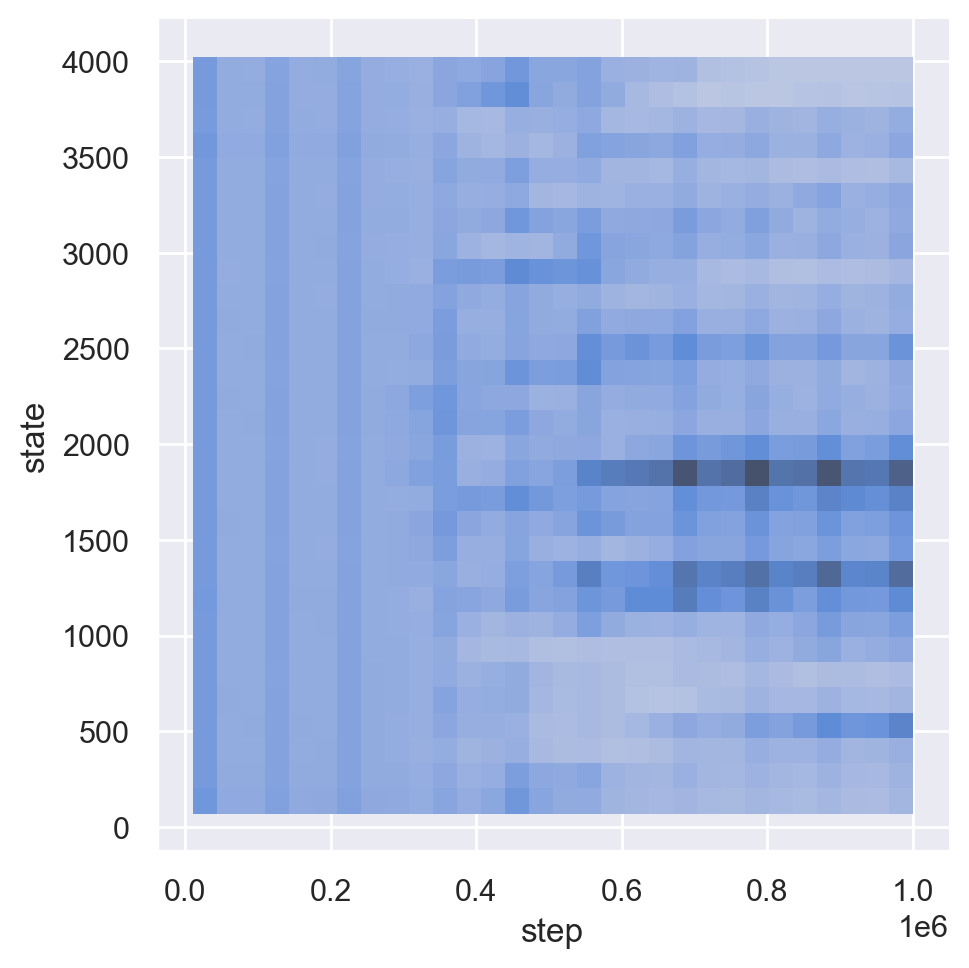

In [72]:
importlib.reload(log_files)

log_files.plot_histograms_per_step(hist[hist['run'] == 'prioritized'], compare_experience_replay=False, cbar=False)

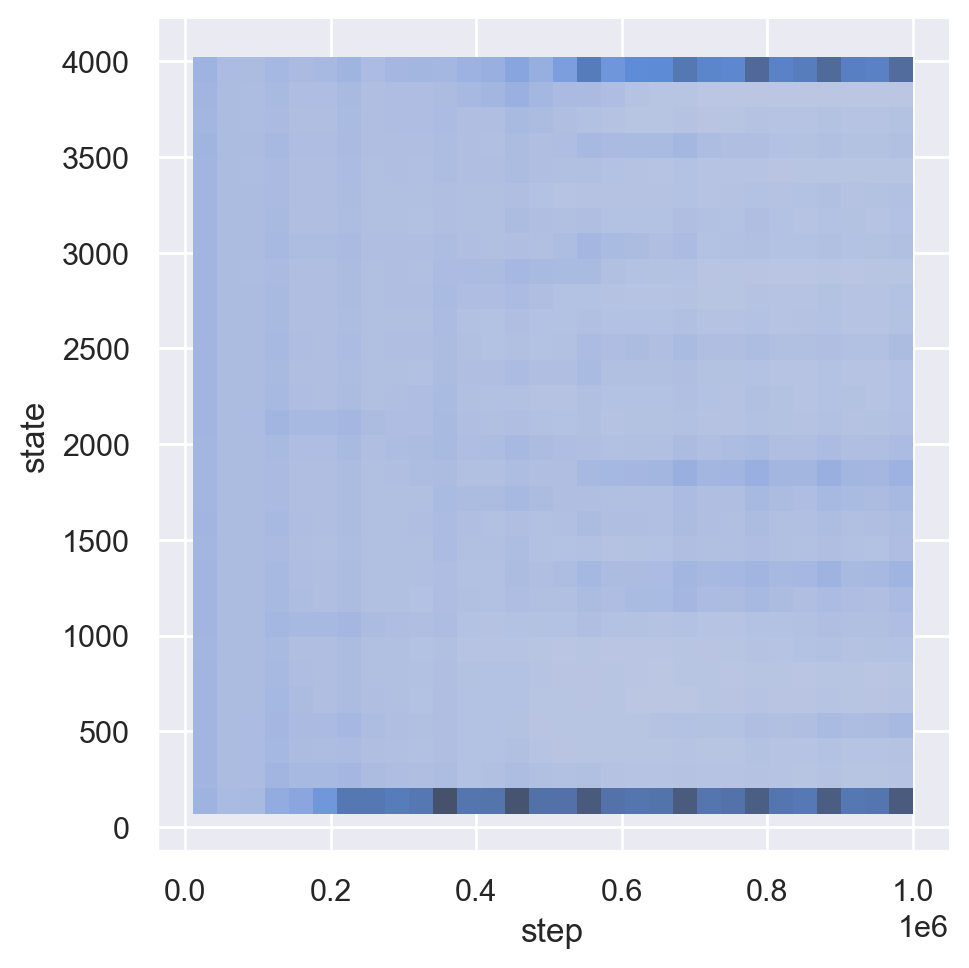

In [73]:
importlib.reload(log_files)

log_files.plot_histograms_per_step(hist[hist['run'] == 'uniform'], compare_experience_replay=False)

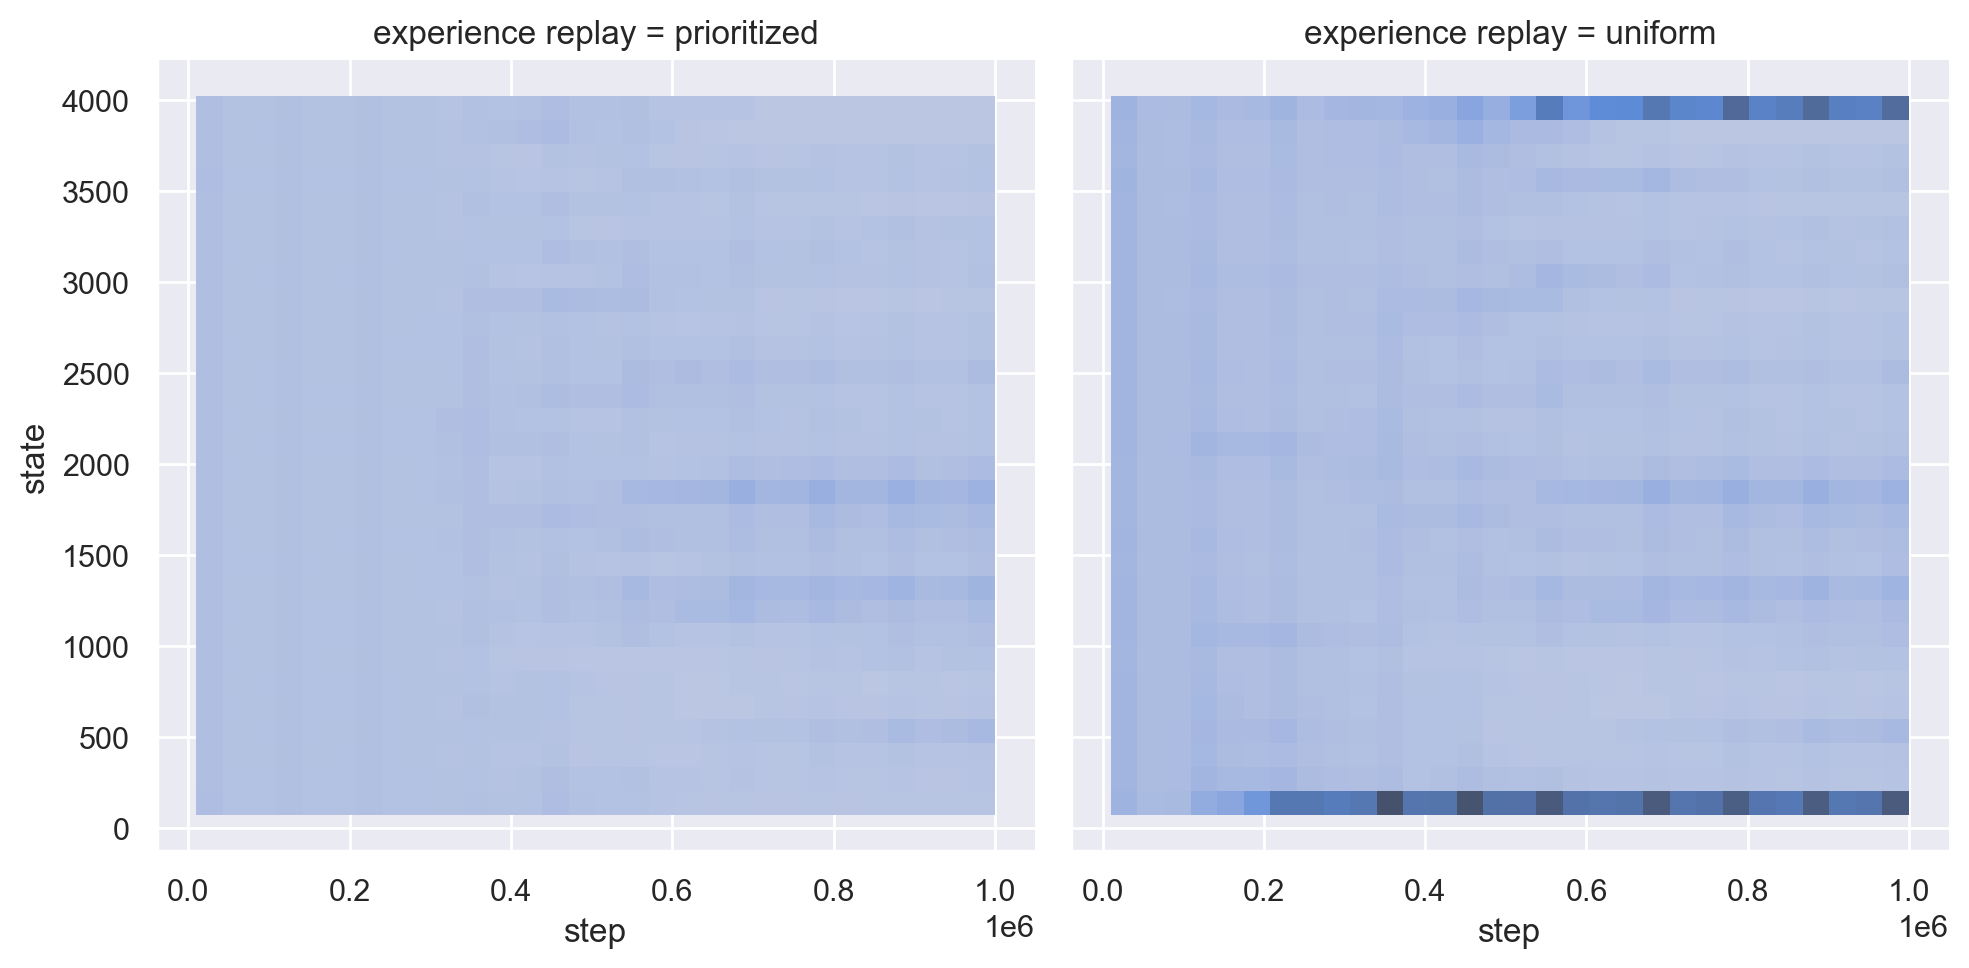

In [74]:
importlib.reload(log_files)

log_files.plot_histograms_per_step(hist, compare_experience_replay=True, cbar=False)

In [256]:
df = hist[hist['run'] == 'prioritized']

bins = np.array([(
    [value[0][..., 0]] +
    [bucket[..., 1] for bucket in value]) for value in df['value']])

bins.shape

(501, 31)

In [255]:
bins.astype('object')

array([[3.0, 139.3, 275.6, ..., 3819.4000000000005, 3955.7000000000003,
        4092.0],
       [3.0, 139.3, 275.6, ..., 3819.4000000000005, 3955.7000000000003,
        4092.0],
       [3.0, 139.3, 275.6, ..., 3819.4000000000005, 3955.7000000000003,
        4092.0],
       ...,
       [3.0, 139.0, 275.0, ..., 3811.0, 3947.0, 4083.0],
       [3.0, 139.0, 275.0, ..., 3811.0, 3947.0, 4083.0],
       [3.0, 139.3, 275.6, ..., 3819.4000000000005, 3955.7000000000003,
        4092.0]], dtype=object)

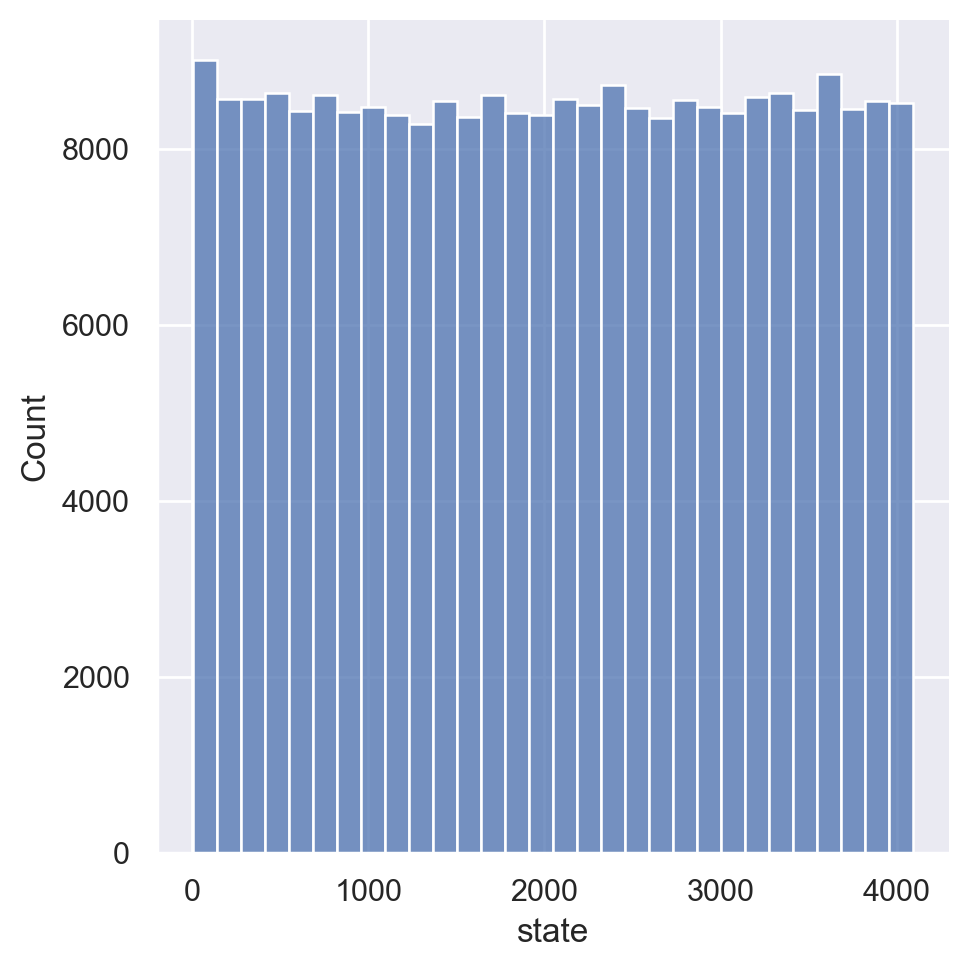

In [250]:
df = pd.DataFrame({"state": data[-1]})
sns.displot(data=df, x="state", bins=bins[-1])

In [223]:
len(data)

1507

In [192]:
[bucket for bucket in df.value]

[array([[3.0000e+00, 1.3930e+02, 8.7980e+03],
        [1.3930e+02, 2.7560e+02, 8.2330e+03],
        [2.7560e+02, 4.1190e+02, 8.4200e+03],
        [4.1190e+02, 5.4820e+02, 8.3690e+03],
        [5.4820e+02, 6.8450e+02, 8.4120e+03],
        [6.8450e+02, 8.2080e+02, 8.5860e+03],
        [8.2080e+02, 9.5710e+02, 8.4860e+03],
        [9.5710e+02, 1.0934e+03, 8.4010e+03],
        [1.0934e+03, 1.2297e+03, 8.4310e+03],
        [1.2297e+03, 1.3660e+03, 8.5430e+03],
        [1.3660e+03, 1.5023e+03, 8.5000e+03],
        [1.5023e+03, 1.6386e+03, 8.6530e+03],
        [1.6386e+03, 1.7749e+03, 8.5210e+03],
        [1.7749e+03, 1.9112e+03, 8.4150e+03],
        [1.9112e+03, 2.0475e+03, 8.5070e+03],
        [2.0475e+03, 2.1838e+03, 8.4790e+03],
        [2.1838e+03, 2.3201e+03, 8.6590e+03],
        [2.3201e+03, 2.4564e+03, 8.4620e+03],
        [2.4564e+03, 2.5927e+03, 8.5490e+03],
        [2.5927e+03, 2.7290e+03, 8.5440e+03],
        [2.7290e+03, 2.8653e+03, 8.3850e+03],
        [2.8653e+03, 3.0016e+03, 8